In [1]:
# Trying to make the NuSTAR solar temperature response in python
# uses the output of f_vth() from make_fvtharray.pro as no thermal
# model in python yet...

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
import ns_tresp

import warnings
warnings.simplefilter('ignore')

In [2]:
# Load in the saved output from f_vth()
# dlogT = 0.05 and dE = 0.04 keV
fvth=io.readsav('fvth_out.dat')

In [3]:
# in units of keV
engs=fvth['eng']
de=engs[1]-engs[0]
logt=fvth['logt']
# in units of photons/s/keV/cm2
phmod=np.array(fvth['fvth'])

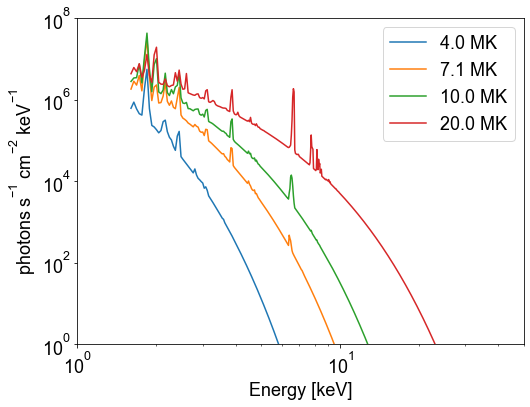

In [4]:
# Check the thermal photon models look ok
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
fig = plt.figure(figsize=(8, 6))
plt.loglog(engs,phmod[:,11],label=str(round(10**(logt[11])*1e-6,1))+' MK')
plt.loglog(engs,phmod[:,16],label=str(round(10**(logt[16])*1e-6,1))+' MK')
plt.loglog(engs,phmod[:,19],label=str(round(10**(logt[19])*1e-6,1))+' MK')
plt.loglog(engs,phmod[:,25],label=str(round(10**(logt[25])*1e-6,1))+' MK')

plt.ylim([1e0,1e8])
plt.xlim([1.,50])
plt.xlabel('Energy [keV]')
plt.ylabel('${photons\;s^{-1}\;cm^{-2}\;keV^{-1}}$')
plt.legend()
fig.show()

In [5]:
# Need to load in the pha, arf and rmf

# Then for the response need to do (1e49 as that's the EM used with f_vth)
# TR = (RMF*ARF) # (phmod*dE/1e49)
# [counts cm^3/s] = [counts cm^2/photons]*[photons/cm^2/s/keV]*[keV]/cm^-3

In [6]:
# Load in the pha, arf and rmf
# Using modified code from https://github.com/KriSun95/krispy/blob/master/krispy/nu_spec.py
mdir='/Users/iain/data/heasarc_nustar/ns_20141101/20012001001/event_cl/spec_l3/'
nsid='20012001001'
fpm='A'

e_lo, e_hi, eff_area = ns_tresp.read_arf(mdir+'nu'+nsid+fpm+'06_sr.arf')

e_lo, e_hi, rmf_mat = ns_tresp.read_rmf(mdir+'nu'+nsid+fpm+'06_sr.rmf')

In [7]:
# Only want the ARF, RMF up to the max energy of the model
nume=len(engs)
arf=eff_area[:nume]
rmf=rmf_mat[0:nume,0:nume]

# And now work out the SRM
# This works but np.multiply doesn't ?!?!?!?
srm = np.array([rmf[r, :] * arf[r] for r in range(len(arf))])

In [8]:
# # Just check it gives stuff similar to IDL...
# ii=np.arange(0,76,15)
# print(ii)
# # IDL version gives 0.790519      7.38509      33.3366      74.0546      99.4546      122.219
# print(arf[ii])
# #  IDL version gives 2.27556e-05    0.0835556    0.0871623    0.0886500    0.0901831    0.0903310
# print(rmf[ii,ii])
# # IDL version gives 1.79887e-05     0.617065      2.90570      6.56493      8.96912      11.0402
# print(srm[ii,ii])
# # Need to transpose to give same indices as idl
# srmt=np.transpose(srm)
# # IDL give 1.79887e-05  6.30194e-05  9.48241e-05      0.00000      0.00000      0.00000
# print(srmt[0,ii])
# # IDL gives 1.79887e-05  8.99434e-06      0.00000      0.00000      0.00000      0.00000
# print(srmt[ii,0])

In [9]:
# phm=phmod[:,10]
# # IDL gives t=10, 452315.72       98437.211       9403.5791       769.87762       92.794373       11.391640
# print(phm[ii])
# # IDL A##B is python A@B so A#B would be B@A in python (or np.matmul(B,A)) ???
# modrate=(phm@srm)*de
# # IDL gives t=10, 18.111596       25500.211       8296.4142       2012.3386       357.91425       55.290528
# print(modrate[ii])

# phm=phmod[:,20]
# # IDL gives t=20, 3234823.2       1667623.1       715650.06       287217.97       130882.81       62085.605
# print(phm[ii])
# # IDL A##B is python A@B so A#B would be B@A in python (or np.matmul(B,A)) ???
# modrate=(phm@srm)*de
# # IDL gives t=20, 422.94550       899806.92       907604.30       784808.24       621237.26       299579.10
# print(modrate[ii])

In [10]:
# Now that we're happy do this for all of them
# Mind that this is the model for an EM of 1e49cm^-3 so need to divide by that before doing the response
n1,n2=phmod.shape
modrs= np.zeros([n1,n2])
for t in np.arange(n2):
    modrs[:,t]=(phmod[:,t]@srm)*de

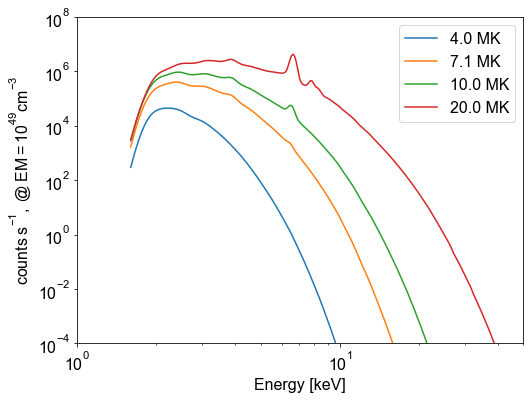

In [11]:
# Check the thermal count models look ok
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
fig = plt.figure(figsize=(8, 6))
plt.loglog(engs,modrs[:,11],label=str(round(10**(logt[11])*1e-6,1))+' MK')
plt.loglog(engs,modrs[:,16],label=str(round(10**(logt[16])*1e-6,1))+' MK')
plt.loglog(engs,modrs[:,19],label=str(round(10**(logt[19])*1e-6,1))+' MK')
plt.loglog(engs,modrs[:,25],label=str(round(10**(logt[25])*1e-6,1))+' MK')
plt.ylim([1e-4,1e8])
plt.xlim([1.,50])
plt.xlabel('Energy [keV]')
plt.ylabel('${counts\;s^{-1},\;@\;EM=10^{49}cm^{-3}}$')
plt.legend()
fig.show()

In [12]:
# Now work out the temeprature response functions for some energy bands
eng_tr=[2.5,4,6,10]
tresp=np.zeros([len(modrs[0,:]),len(eng_tr)-1])

for i in np.arange(len(eng_tr)-1):
    gd=np.where((e_lo >= eng_tr[i]) & (e_hi < eng_tr[i+1]) )
    mm=np.sum(modrs[gd,:],axis=1)
    tresp[:,i]=mm[0,:]/1e49


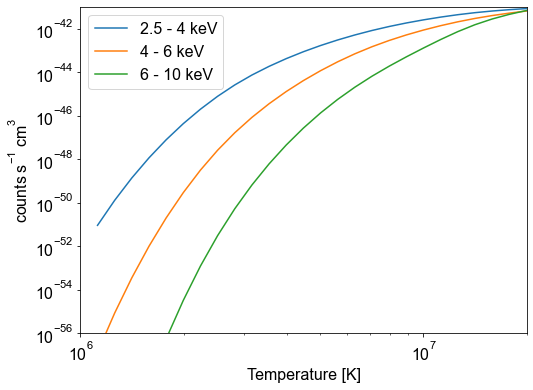

In [13]:
# Plot the responses
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
fig = plt.figure(figsize=(8, 6))
for i in np.arange(len(eng_tr)-1):
    plt.loglog(10**logt,tresp[:,i],label=str(eng_tr[i])+' - '+str(eng_tr[i+1])+ ' keV')

plt.ylim([1e-56,1e-41])
plt.xlim([1e6,2e7])
plt.xlabel('Temperature [K]')
plt.ylabel('${counts\;s^{-1}\;cm^{3}}$')
plt.legend()
fig.show()

In [14]:
# Now just need to load in the pha
engs,cnts,lvtm,ontim=ns_tresp.read_pha(mdir+'nu'+nsid+fpm+'06_sr.pha')

In [15]:
# Work out the total count rate and error in the energy bands
rate=np.zeros(len(eng_tr)-1)
erate=np.zeros(len(eng_tr)-1)
               
for i in np.arange(len(eng_tr)-1):
    gd=np.where((engs >= eng_tr[i]) & (engs < eng_tr[i+1]) )
    rate[i]=np.sum(cnts[gd])/lvtm
    erate[i]=np.sqrt(np.sum(cnts[gd]))/lvtm
print(rate)
print(erate)

[3999.60838492  319.96867079   11.91030264]
[35.88139105 10.14878997  1.95804169]


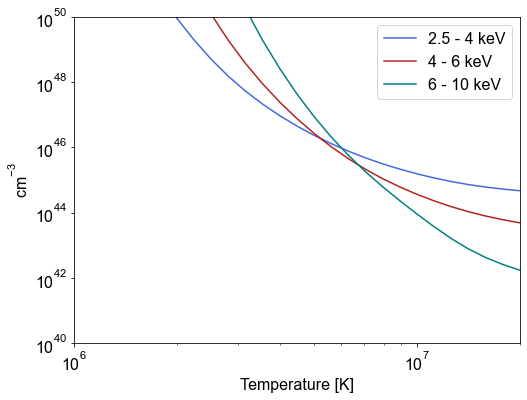

In [16]:
# Finally plot the EM Loci
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
fig = plt.figure(figsize=(8, 6))
clrs=['royalblue','firebrick','teal']
for i in np.arange(len(eng_tr)-1):
    plt.loglog(10**logt,rate[i]/tresp[:,i],label=str(eng_tr[i])+' - '+str(eng_tr[i+1])+ ' keV',color=clrs[i])
plt.ylim([1e40,1e50])
plt.xlim([1e6,2e7])
plt.xlabel('Temperature [K]')
plt.ylabel('${cm^{-3}}$')
plt.legend()
fig.show()